In [180]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

In [47]:
# Read Data
data = pd.read_csv('code/UrbanSound8K/metadata/UrbanSound8K.csv')
data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [15]:
data.shape

(8732, 8)

In [48]:
# Get data over 3 seconds long
valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]
valid_data.shape

(7468, 4)

In [181]:
# Example of a Siren spectrogram
y, sr = librosa.load('code/UrbanSound8K/audio/fold6/135160-8-0-0.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

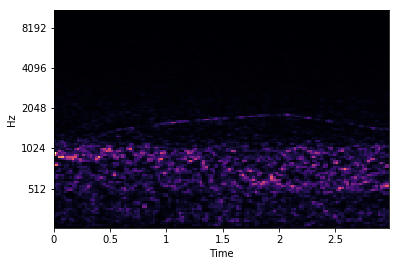

In [182]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [184]:
# Example of a AC spectrogram
y, sr = librosa.load('code/UrbanSound8K/audio/fold1/134717-0-0-19.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

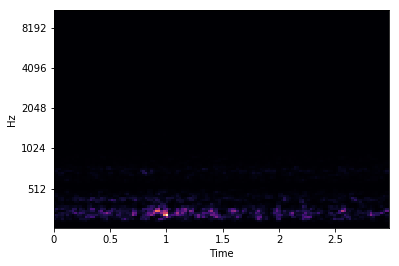

In [185]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [186]:
# Example of a children playing spectrogram
y, sr = librosa.load('code/UrbanSound8K/audio/fold9/13579-2-0-16.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

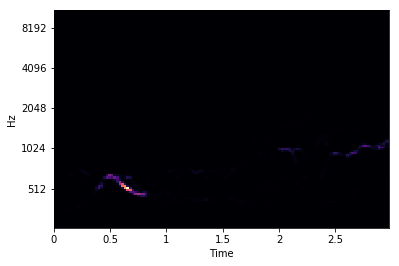

In [187]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [188]:
# Example of a drilling spectrogram
y, sr = librosa.load('code/UrbanSound8K/audio/fold9/137815-4-0-0.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

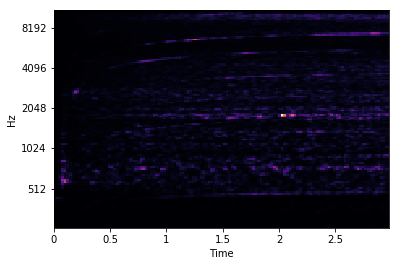

In [189]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

Iterate over all samples in _valid_.
For every sample, construct the (128,128) spectrogram

In [56]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [174]:
D = [] # Dataset

for row in valid_data.itertuples():
    y, sr = librosa.load('code/UrbanSound8K/audio/' + row.path, duration=2.97)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 128): continue
    D.append( (ps, row.classID) )

In [175]:
print("Number of samples: ", len(D))

Number of samples:  7467


In [176]:
dataset = D
random.shuffle(dataset)

train = dataset[:7000]
test = dataset[7000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [177]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

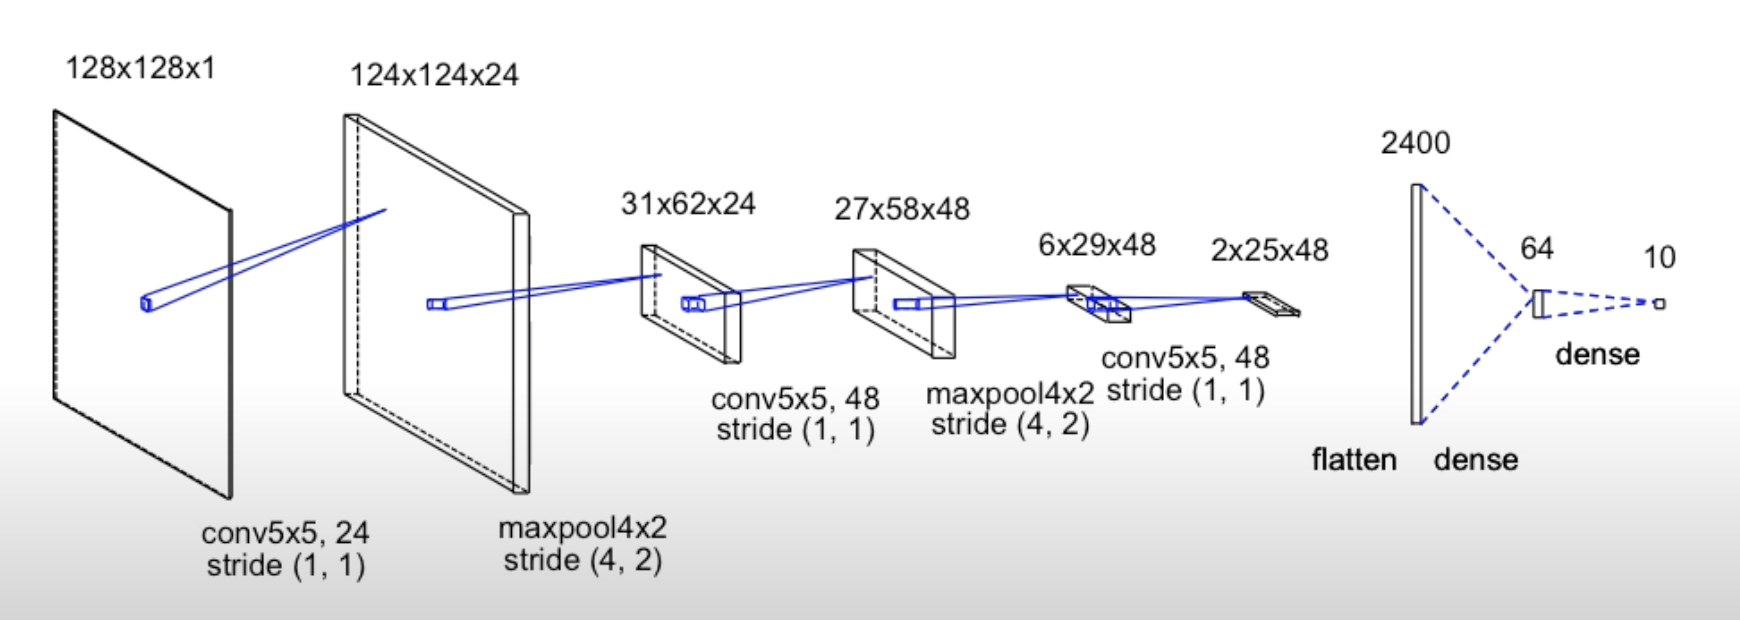

In [178]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7000 samples, validate on 467 samples
Epoch 1/12
7000/7000 [==============================] - 180s 26ms/step - loss: 2.6048 - acc: 0.2070 - val_loss: 2.0851 - val_acc: 0.3233
Epoch 2/12
7000/7000 [==============================] - 181s 26ms/step - loss: 2.0906 - acc: 0.2699 - val_loss: 1.7804 - val_acc: 0.3833
Epoch 3/12
7000/7000 [==============================] - 178s 25ms/step - loss: 1.8462 - acc: 0.3520 - val_loss: 1.5282 - val_acc: 0.4732
Epoch 4/12
7000/7000 [==============================] - 176s 25ms/step - loss: 1.7039 - acc: 0.4081 - val_loss: 1.3940 - val_acc: 0.5096
Epoch 5/12
7000/7000 [==============================] - 183s 26ms/step - loss: 1.5457 - acc: 0.4536 - val_loss: 1.2631 - val_acc: 0.5546
Epoch 6/12
7000/7000 [==============================] - 163s 23ms/step - loss: 1.4177 - acc: 0.5024 - val_loss: 1.1702 - val_acc: 0.6060
Epoch 7/12
7000/7000 [==============================] - 166s 24ms/step - loss: 1.3528 - acc: 0.5274 - val_loss: 1.1287 - val_acc: 0

We are able to get over $70-75\%$ accuracy. Nice!

## Data Augmentation

### 1. Vary Time

In [ ]:
y, sr = librosa.load('code/UrbanSound8K/audio/fold1/14113-4-0-1.wav', duration=2.97)
y_changed = librosa.effects.time_stretch(y, rate=0.81)
librosa.output.write_wav('code/augmented/fold1/speed_81/14113-4-0-1.wav' ,y_changed, sr)

In [ ]:
rate = 1.07 # replace with 0.81 and execute again

for row in valid_data.itertuples():
    y, sr = librosa.load('code/UrbanSound8K/audio/' + row.path)  
    y_changed = librosa.effects.time_stretch(y, rate=rate)
    librosa.output.write_wav('code/augmented/fold' + str(row.fold) + '/speed_' + str(int(rate*100)) + '/' + row.slice_file_name ,y_changed, sr)

### 2. Vary pitch

In [ ]:
n_steps = 2 #-1, -2, 2, 1

for row in valid_data.itertuples():
    y, sr = librosa.load('code/UrbanSound8K/audio/' + row.path)  
    y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
    librosa.output.write_wav('code/augmented/fold' + str(row.fold) + '/ps1_' + str(int(n_steps)) + '/' + row.slice_file_name ,y_changed, sr)

### 3. Change Pitch (PS2)

In [ ]:
n_steps = 2.5 #-2.5, -3.5, 2.5, 3.5

for row in valid_data.itertuples():
    y, sr = librosa.load('code/UrbanSound8K/audio/' + row.path)  
    y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
    librosa.output.write_wav('code/augmented/fold' + str(row.fold) + '/ps2_m' + str(int(n_steps*10)) + '/' + row.slice_file_name ,y_changed, sr)

In [152]:
len(D)

37310

The dataset consists of:
- 1-7467 normal samples.
- 7468-14934 samples Pitch modulated 2.5 semitones higher.
- 14935-22401 samples Pitch modeulated 2 semitones higher.
- 22402-29869 samples Slowed down to 0.81.
- 29869-37310 samples speed up by 1.07

Follow the same procedure for the normal data.

In [153]:
dataset = D
random.shuffle(dataset)

train = dataset[:35000]
test = dataset[35000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [155]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [156]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 35000 samples, validate on 2310 samples
Epoch 1/12
35000/35000 [==============================] - 982s 28ms/step - loss: 1.9844 - acc: 0.3104 - val_loss: 1.4893 - val_acc: 0.4844
Epoch 2/12
35000/35000 [==============================] - 881s 25ms/step - loss: 1.4384 - acc: 0.4950 - val_loss: 1.1614 - val_acc: 0.6251
Epoch 3/12
35000/35000 [==============================] - 947s 27ms/step - loss: 1.1681 - acc: 0.6005 - val_loss: 0.9777 - val_acc: 0.6710
Epoch 4/12
35000/35000 [==============================] - 917s 26ms/step - loss: 0.9994 - acc: 0.6680 - val_loss: 0.8171 - val_acc: 0.7437
Epoch 5/12
35000/35000 [==============================] - 1335s 38ms/step - loss: 0.8709 - acc: 0.7135 - val_loss: 0.7054 - val_acc: 0.7749
Epoch 6/12
35000/35000 [==============================] - 960s 27ms/step - loss: 0.7779 - acc: 0.7450 - val_loss: 0.5937 - val_acc: 0.8091
Epoch 7/12
35000/35000 [==============================] - 919s 26ms/step - loss: 0.6882 - acc: 0.7743 - val_loss: 0.

With data augmentation, we get upto $82\%$. 